In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

# (l,k)-discrepancy
This notebook presents the results exposed in the last part of *link*.    
What directly follows are some global constants definitions.

In [2]:
# Named n in the paper, the input dimension
# is of 2 here as we use a binary alphabet
# to compute the lk-discrepancy.
input_dimension = 2

zero = np.array([1.0,0.0])
one = np.array([0.0,1.0])

# The logistic sigmoid function.
def sig(x):
    return 1/(1+np.exp(-x))

## Vanilla RNNs
What follows is the implementation of Vanilla RNNs

In [3]:
# RNNv function implements the Vanilla model:
# it computes the sequence of hidden states h_seq you get
# when you start with h0 (= h_{-1} in the paper) and input sequence x_seq
# in a Vanilla RNN paramatrized by Uh and Wh.
def RNNv(x_seq,h0,Uh,Wh):
    h_seq = [h0]
    for x in x_seq:
        h = sig(Uh.dot(x)+Wh.dot(h_seq[-1]))
        h_seq.append(h)
    return h_seq[-1]

def RNNv_init_uni(k):
    global input_dimension
    Uh = np.random.uniform(-np.sqrt(1./input_dimension), np.sqrt(1./input_dimension), (k, input_dimension)) # input to hidden
    Wh = np.random.uniform(-np.sqrt(1./k), np.sqrt(1./k), (k, k)) # hidden to hidden
    return Uh,Wh

def RNNv_init_norm(k):
    global input_dimension
    Uh = np.random.randn(k,input_dimension)
    Wh = np.random.randn(k,k)
    return Uh,Wh

def RNNv_init_norm_xavier(k):
    global input_dimension
    Uh = np.sqrt(1./input_dimension)*np.random.randn(k,input_dimension)
    Wh = np.sqrt(1./k)*np.random.randn(k,k)
    return Uh,Wh

## GRU RNNs
What follows is the implementation of GRU RNNs

In [4]:
# GRU function implements the GRU model:
# it computes the sequence of hidden states h_seq you get
# when you start with h0 (= h_{-1} in the paper) and input sequence x_seq
# in a GRU RNN paramatrized by Uz,Wz,Ur,Wr,Uhp,Whp.
def GRU(x_seq,h0,Uz,Wz,Ur,Wr,Uhp,Whp):
    h_seq = [h0]
    for x in x_seq:
        z = sig(Uz.dot(x)+Wz.dot(h_seq[-1]))
        r = sig(Ur.dot(x)+Wr.dot(h_seq[-1]))
        hp = np.tanh(Uhp.dot(x)+Whp.dot(h_seq[-1]*r))
        h_seq.append((1-z)*hp+z*h_seq[-1])
    return h_seq[-1]

def GRU_init_uni(k):
    global input_dimension
    Uz = np.random.uniform(-np.sqrt(1./input_dimension), np.sqrt(1./input_dimension), (k, input_dimension)) # input to hidden
    Wz = np.random.uniform(-np.sqrt(1./k), np.sqrt(1./k), (k, k)) # hidden to hidden
    Ur = np.random.uniform(-np.sqrt(1./input_dimension), np.sqrt(1./input_dimension), (k, input_dimension)) # input to hidden
    Wr = np.random.uniform(-np.sqrt(1./k), np.sqrt(1./k), (k, k)) # hidden to hidden
    Uhp = np.random.uniform(-np.sqrt(1./input_dimension), np.sqrt(1./input_dimension), (k, input_dimension)) # input to hidden
    Whp = np.random.uniform(-np.sqrt(1./k), np.sqrt(1./k), (k, k)) # hidden to hidden
    return Uz,Wz,Ur,Wr,Uhp,Whp

def GRU_init_norm(k):
    global input_dimension
    Uz = np.random.randn(k,input_dimension)
    Wz = np.random.randn(k,k)
    Ur= np.random.randn(k,input_dimension)
    Wr = np.random.randn(k,k)
    Uhp = np.random.randn(k,input_dimension)
    Whp = np.random.randn(k,k)
    return Uz,Wz,Ur,Wr,Uhp,Whp
    
def GRU_init_norm_xavier(k):
    global input_dimension
    Uz = np.sqrt(1./input_dimension)*np.random.randn(k,input_dimension)
    Wz = np.sqrt(1./k)*np.random.randn(k,k)
    Ur= np.sqrt(1./input_dimension)*np.random.randn(k,input_dimension)
    Wr = np.sqrt(1./k)*np.random.randn(k,k)
    Uhp = np.sqrt(1./input_dimension)*np.random.randn(k,input_dimension)
    Whp = np.sqrt(1./k)*np.random.randn(k,k)
    return Uz,Wz,Ur,Wr,Uhp,Whp

## (l,k)-discrepancy computation
What follows is the generic way to compute the (l,k)-discrepancy for a sequential model.

In [5]:
def lk_descrepancy(model,model_init,l,k,n_iter=2000):
    global input_dimension,zero,one
    
    l_seq0 = [zero for i in range(l)]
    l_seq1 = [zero for i in range(l)]
    l_seq1[0] = one

    h0 = np.zeros(k)
    
    results = []
    for i in  range(n_iter):
        params = model_init(k)
        results.append(np.linalg.norm((model(l_seq0,h0,*params)-model(l_seq1,h0,*params))))
    
    return np.array(results).mean()

def compute_block_lk_discrepancy(model,model_init,l_range,k_range):
    x = np.ones((l_range[1]-l_range[0]+1,k_range[1]-k_range[0]+1))
    for l in range(x.shape[0]):
        for k in range(x.shape[1]):
            x[l,k] = l+l_range[0]
            
    y = np.ones((l_range[1]-l_range[0]+1,k_range[1]-k_range[0]+1))
    for l in range(y.shape[0]):
        for k in range(y.shape[1]):
            y[l,k] = k+k_range[0]
    
    z = np.ones((l_range[1]-l_range[0]+1,k_range[1]-k_range[0]+1))
    print('Current l: ')
    for l in range(z.shape[0]):
        sys.stdout.write(str(l+l_range[0])+', ')
        for k in range(z.shape[1]):
            z[l,k] = lk_descrepancy(model,model_init,int(x[l,k]),int(y[l,k]))
    
    return x,y,z

def plot_lk_discrepancy(model,model_init,l_range=(1,30),k_range=(1,30)):
    plt.figure(figsize=(10,7))
    x,y,z = compute_block_lk_discrepancy(model,model_init,l_range, k_range)    
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    plt.show()

## (l,k)-discrepancy for Vanilla RNNs
### With Gaussian initializations
#### N(0,1)

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

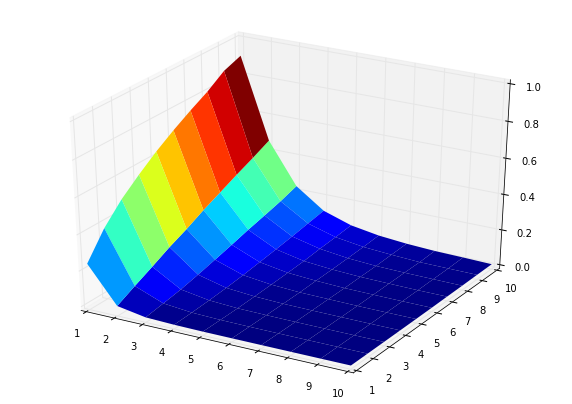

In [6]:
plot_lk_discrepancy(RNNv, RNNv_init_norm, (1,10),(1,10))

#### Xavier's method (as implemented in Caffee)

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

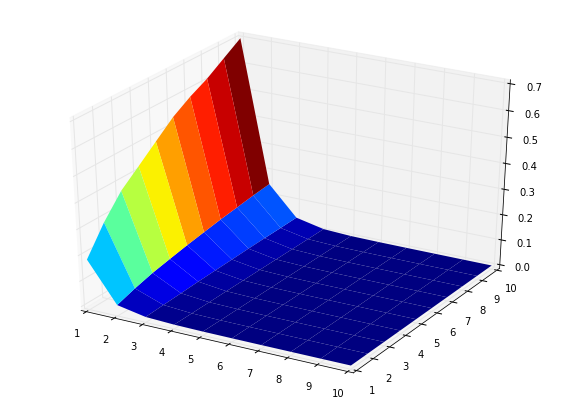

In [7]:
plot_lk_discrepancy(RNNv, RNNv_init_norm_xavier, (1,10),(1,10))

### With uniform initialization

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

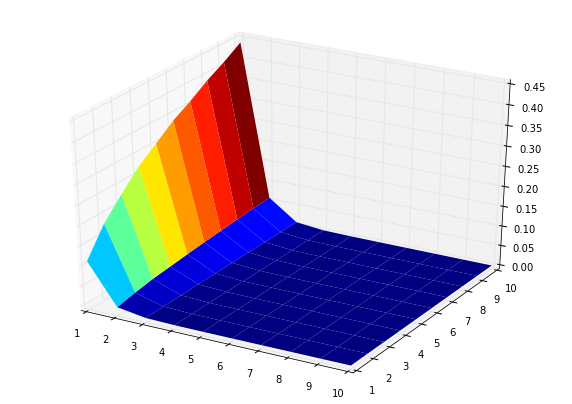

In [8]:
plot_lk_discrepancy(RNNv, RNNv_init_uni, (1,10),(1,10))

## (l,k)-discrepancy for GRU RNNs
### With Gaussian initialization
#### N(0,1)

In [ ]:
plot_lk_discrepancy(GRU, GRU_init_norm, (1,10),(1,10))

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 

#### Xavier's method (as implemented in Caffee)

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

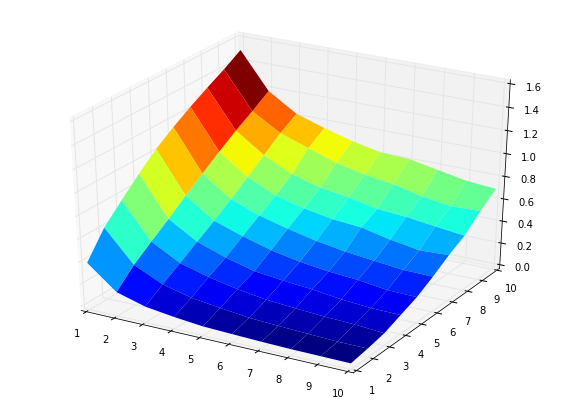

In [13]:
plot_lk_discrepancy(GRU, GRU_init_norm2, (1,10),(1,10))

### With uniform initialization

Current l: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

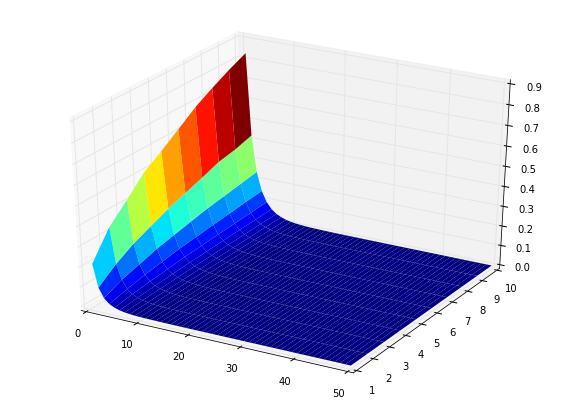

In [22]:
plot_lk_discrepancy(GRU, GRU_init_uni, (1,50),(1,10))